In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from utils.visualize import *
from utils.FIR_filter import *
from utils.signal_process import *
from utils.preprocess import *
from utils.model import *

import torch
from torch.utils.data import Dataset, DataLoader

import pickle

## Step-by-Step Data Preprocessing Demo

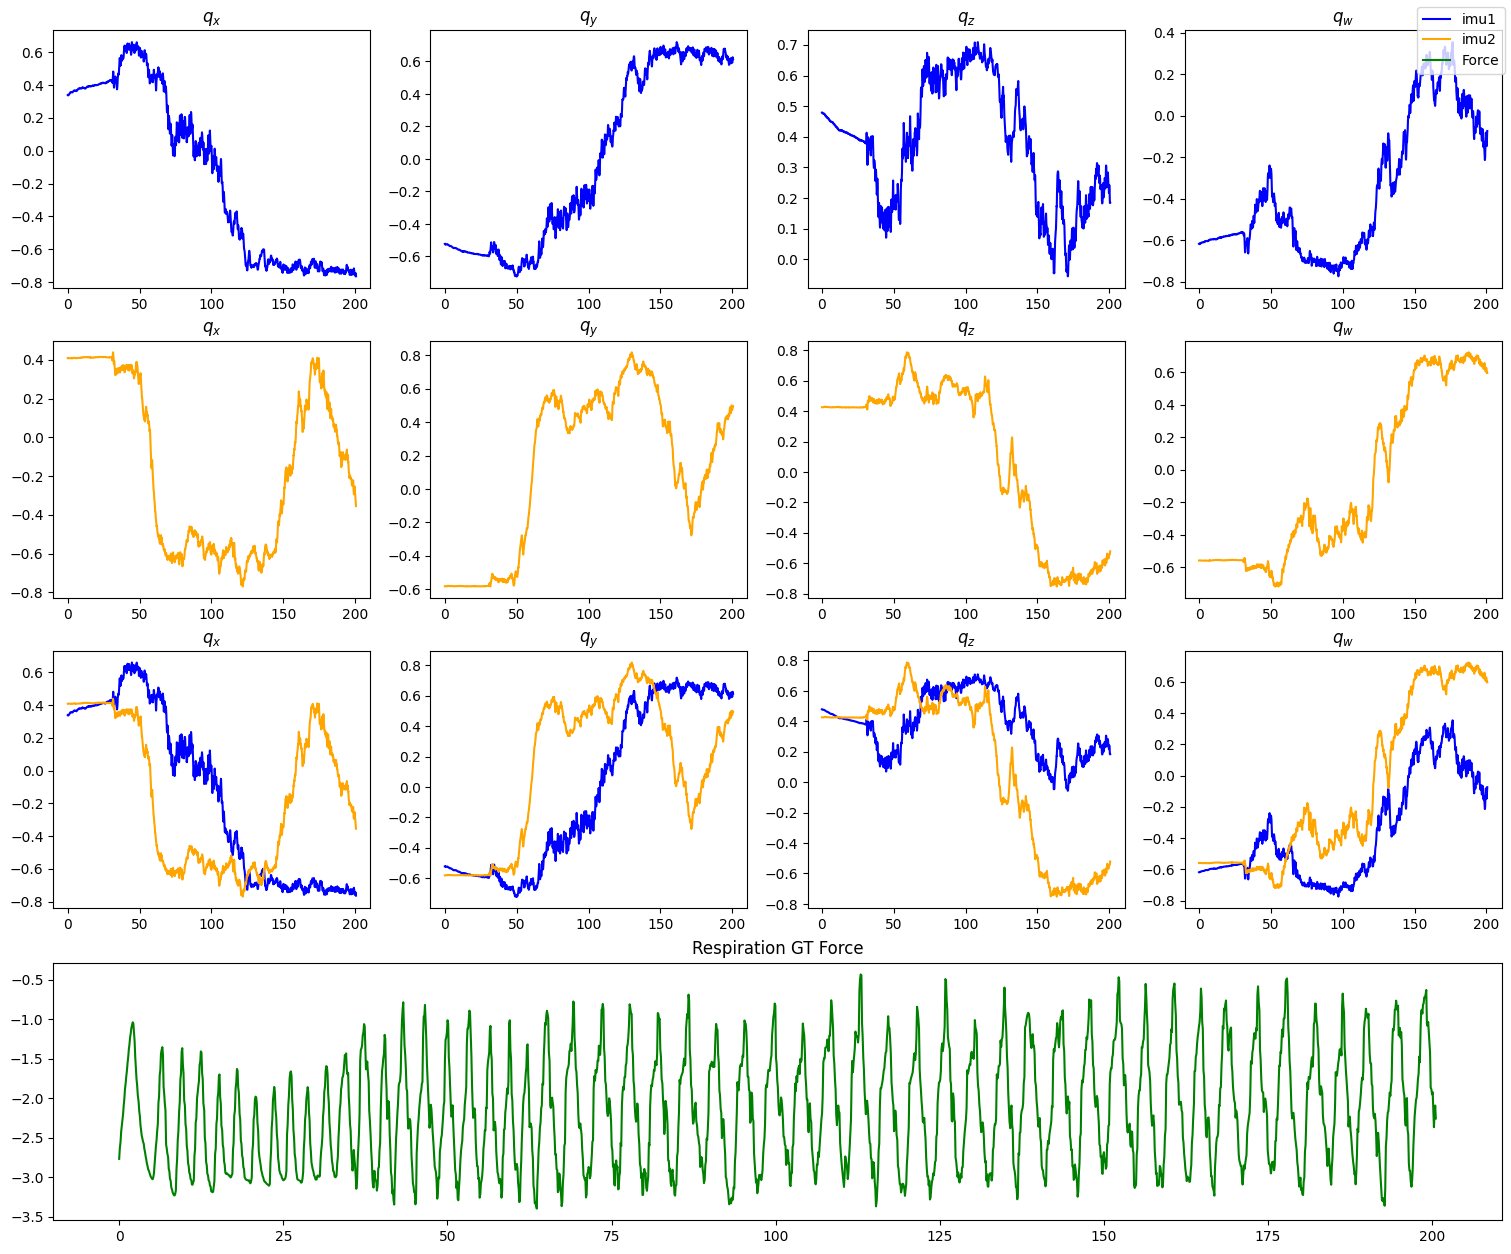

In [2]:
fs = 10
start_pt, end_pt = 0, -1
still_pt = 300 # 500

file_path = "./data/8P/test/walk_0514_1043.csv"
# file_path = "./data/5_16/kiri/sit_0516_0535.csv" # sit_0516_0501, sit_0516_0509, sit_0516_0523, sit_0516_0535, stand_0516_0548, walk_0516_0650, run_0516_0741

data = pd.read_csv(file_path)
data.columns = [
    "Timestamp",
    "imu1_q_x",
    "imu1_q_y",
    "imu1_q_z",
    "imu1_q_w",
    "imu2_q_x",
    "imu2_q_y",
    "imu2_q_z",
    "imu2_q_w",
    "Force",
    "RR",
]
sensor_names=['imu1','imu2']
cols = ['q_x', 'q_y', 'q_z', 'q_w']
data = data.iloc[start_pt:end_pt]

data = align_delay(data, delay=10)
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data = data.set_index("Timestamp")

draw_imu_curve(data, overlap=True, show_gt=True)
# draw_imu_curve(data, overlap=True, show_gt=False)

best_score/total: 133/300


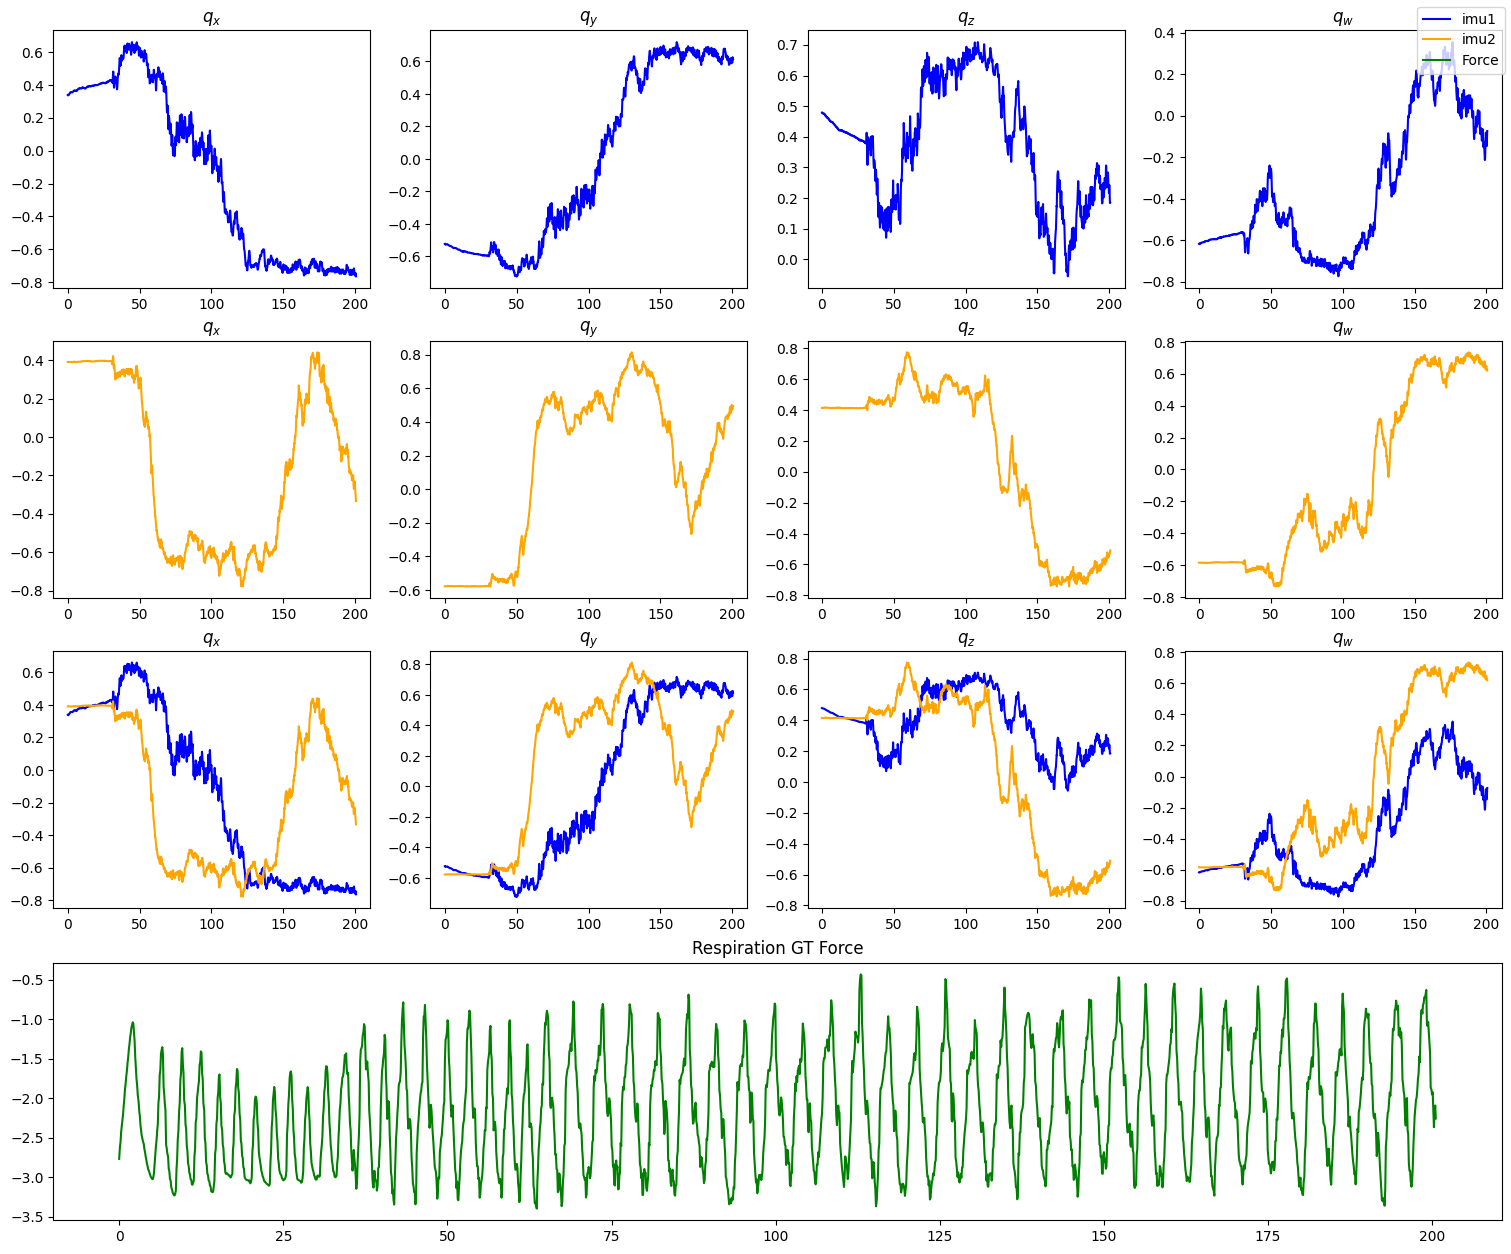

In [3]:
# Align IMUs (IMU2 -> IMU1)
q_corr = Q_RANSAC(data[0:still_pt], pool=1.0, d=0.05)

target, skew = 'imu1', 'imu2'
Q_skew = data[[skew + '_q_x', skew + '_q_y', skew + '_q_z', skew + '_q_w']].to_numpy()
Q_aligned = align_quaternion(q_corr, Q_skew) # (sample num, 4)
data_aligned = data.copy()

for i, col in enumerate(cols):
    data_aligned[[skew + '_' + col]] = Q_aligned[:, i].reshape(-1, 1)

draw_imu_curve(data_aligned, overlap=True, show_gt=True)

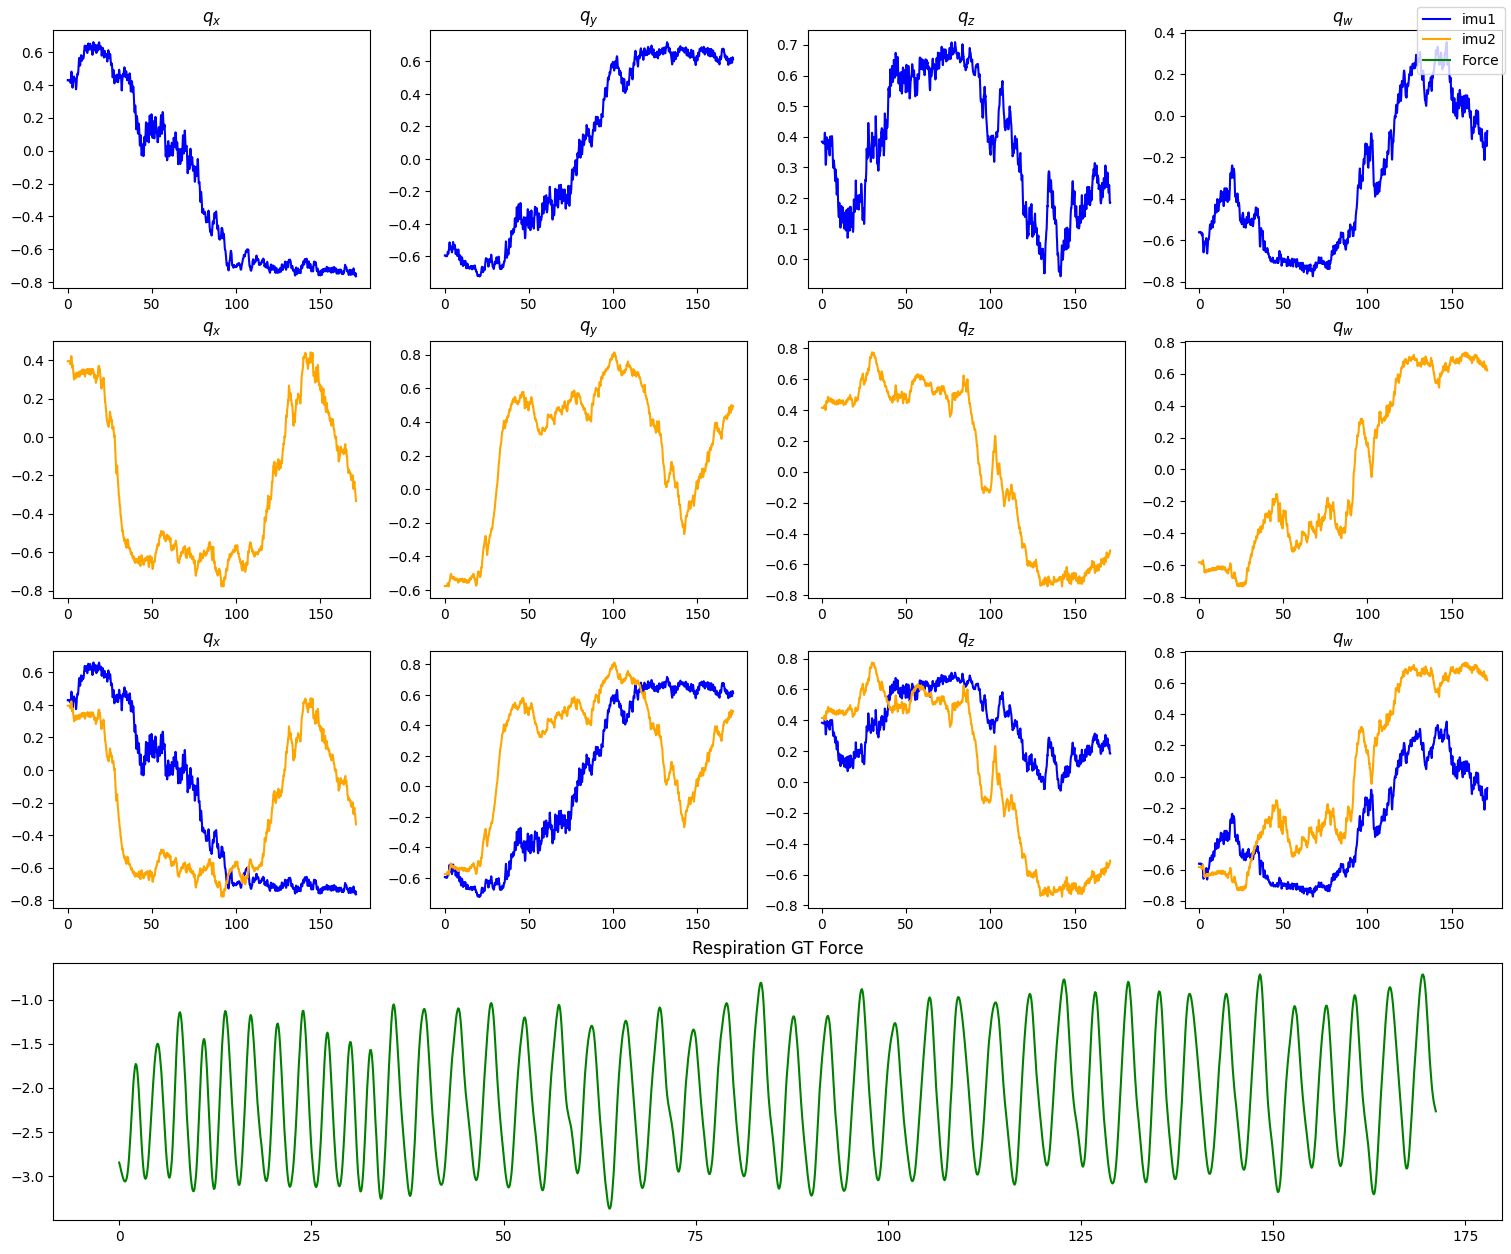

In [4]:
# Handle gt force
data_sp = data_aligned # data used in compute spectrogram shape
data_sp = data_sp[still_pt+0:]
cols = ['q_x', 'q_y', 'q_z', 'q_w'] # for quaternion

data_sp.loc[:, "Force"] = butter_filter(data_sp["Force"], cutoff=0.66)
draw_imu_curve(data_sp, overlap=True, show_gt=True)

## Compute Model Parameters (Spectrogram Shape)

In [5]:
# 1-D spectrogram
# window_size=128
# stride=64
# nperseg=128
# noverlap=64
# out1=True

# 2-D spectrogram
window_size=256
stride=64
nperseg=128
noverlap=64
out1=True

spectrograms_file, gts_file, times_file = prepare_file(file_path, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=out1)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

num_channels = spectrograms_file.shape[1]
num_freq_bins = spectrograms_file.shape[2]  # From computed spectrogram
num_time_steps = spectrograms_file.shape[3]  # From computed spectrogram

best_score/total: 133/300
----------------------------
sepctrograms:(24, 16, 65, 3)
gt:(24, 1)
times:(24, 1)


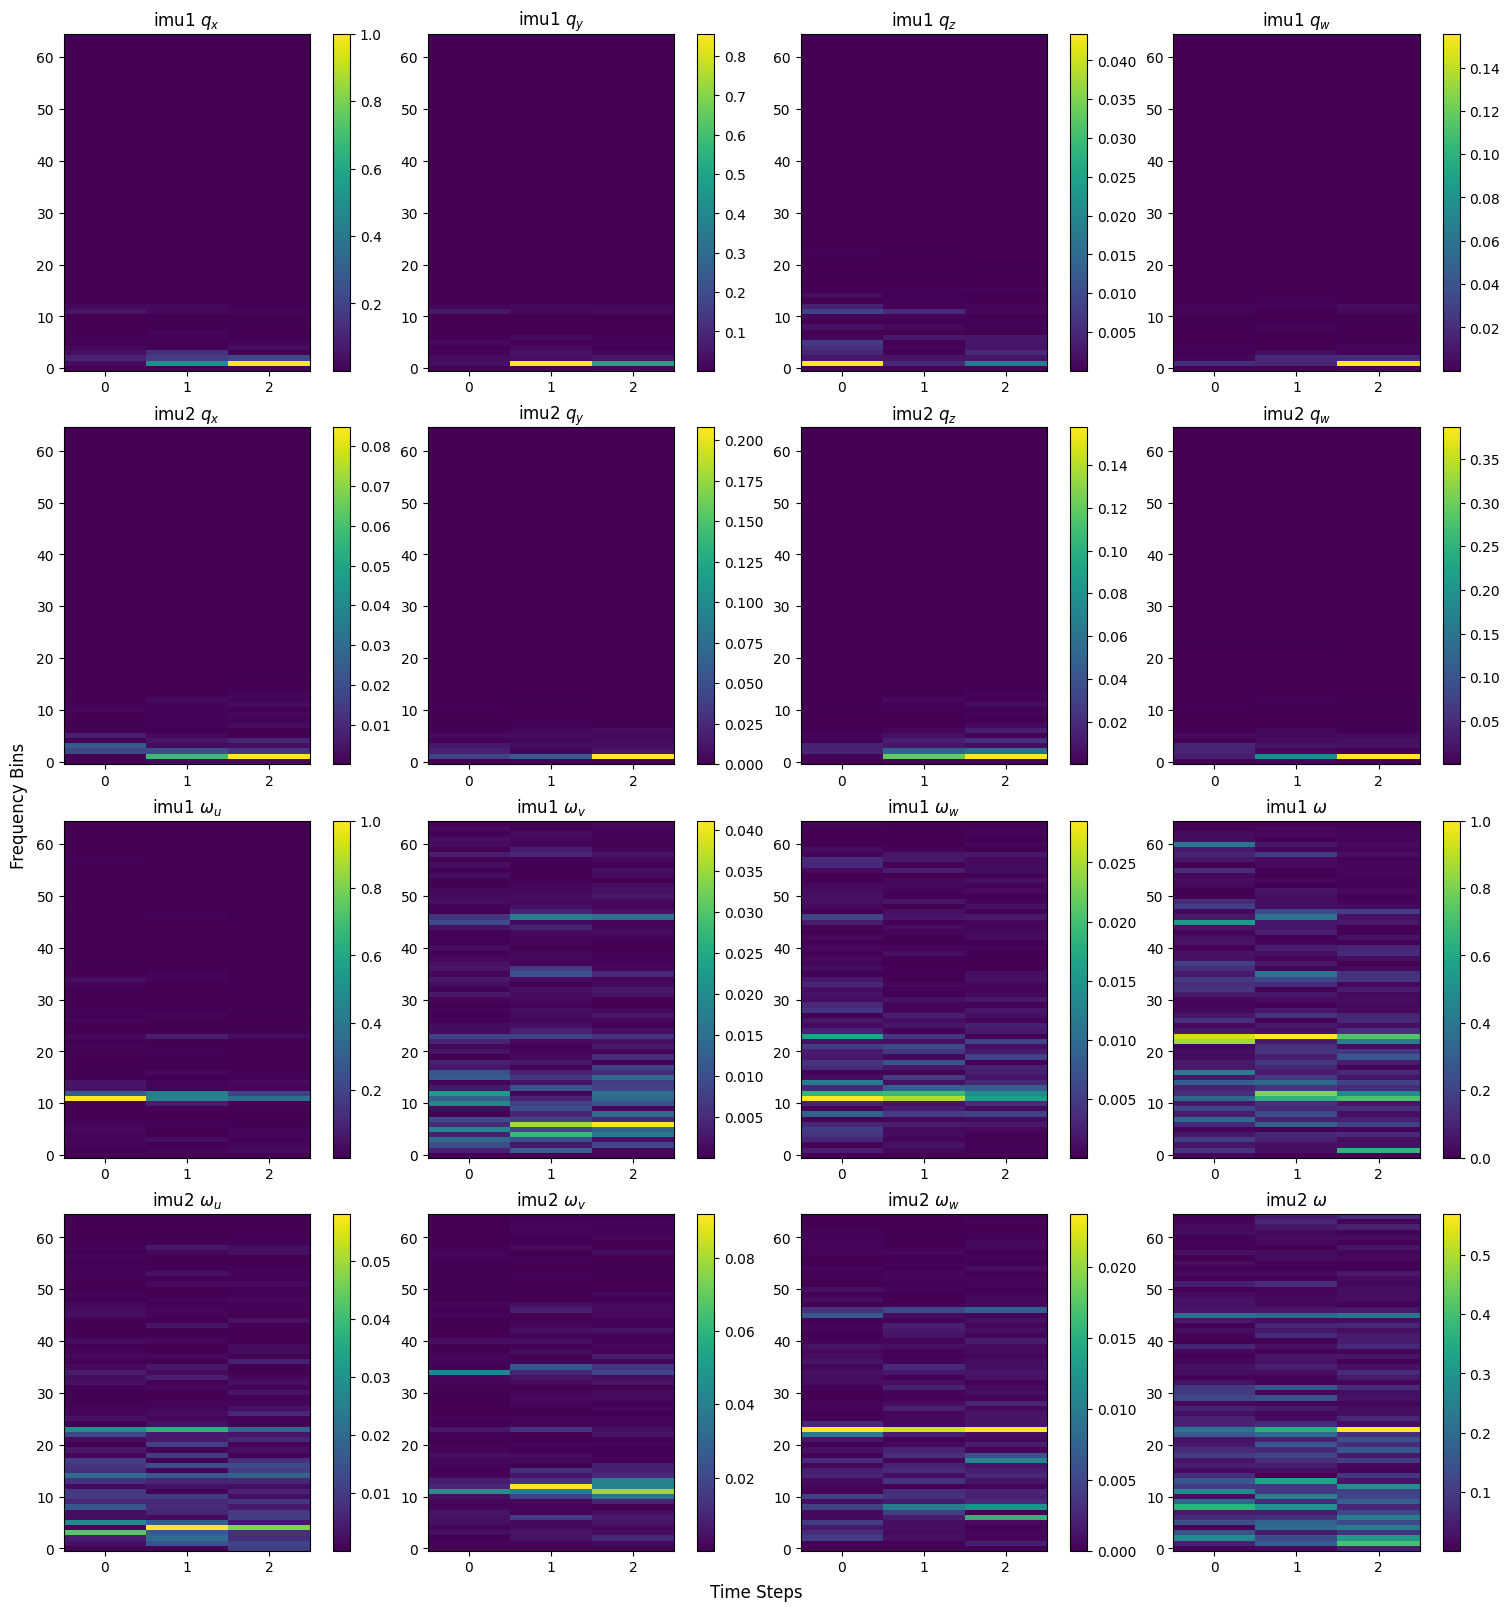

In [6]:
# show one spectrogram
plot_spectrogram_16(spectrograms_file[10])

In [7]:
torch.cuda.is_available()

True

## Testing Model

In [8]:
# Load dataset
dataset_dir = "dataset/"
dataset_name = "8P_16_2D"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']

print('Testing data......')
print(f'Testing shape: {input_test.shape}')

num_channels = input_test.shape[1]
num_freq_bins = input_test.shape[2]
num_time_steps = input_test.shape[3]

dataset_test = IMUSpectrogramDataset(input_test, gt_test)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=True)

Testing data......
Testing shape: (339, 16, 65, 3)


In [12]:
# Test one file
action_name = "sit_0514_1030"
path_file = f'./data/8P/test/{action_name}.csv'

# spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap)
spectrograms_file, gts_file, times_file = prepare_file(path_file, window_size=window_size, stride=stride, nperseg=nperseg, noverlap=noverlap, out_1=True)
dataset_file= IMUSpectrogramDataset(spectrograms_file, gts_file)
file_loader = DataLoader(dataset_file, batch_size=1, shuffle=False)

best_score/total: 300/300
----------------------------
sepctrograms:(24, 16, 65, 3)
gt:(24, 1)
times:(24, 1)


In [13]:
# Load models
# 2-D spectrogram
models_name = ['MLP_8P_2D', 'CNN_8P_2D', 'BiLSTM_8P_2D', 'GRU_8P_2D']
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Evaluate model in whole testing set
    mse, mae = evaluate_model(models[i], test_loader, model_name=models_name[i], device=device)

MLP_8P_2D Evaluation Results - MSE Loss: 0.0056, L1 Loss: 3.0839 1/min
CNN_8P_2D Evaluation Results - MSE Loss: 0.0039, L1 Loss: 3.1152 1/min
BiLSTM_8P_2D Evaluation Results - MSE Loss: 0.0050, L1 Loss: 2.9266 1/min
GRU_8P_2D Evaluation Results - MSE Loss: 0.0051, L1 Loss: 2.8448 1/min


MLP_2D Evaluation Results - MSE Loss: 0.0001, L1 Loss: 0.6007 1/min, R²:0.4975
CNN_2D Evaluation Results - MSE Loss: 0.0060, L1 Loss: 4.5904 1/min, R²:-20.6193
BiLSTM_2D Evaluation Results - MSE Loss: 0.0002, L1 Loss: 0.6823 1/min, R²:0.3209
GRU_2D Evaluation Results - MSE Loss: 0.0000, L1 Loss: 0.3494 1/min, R²:0.8227


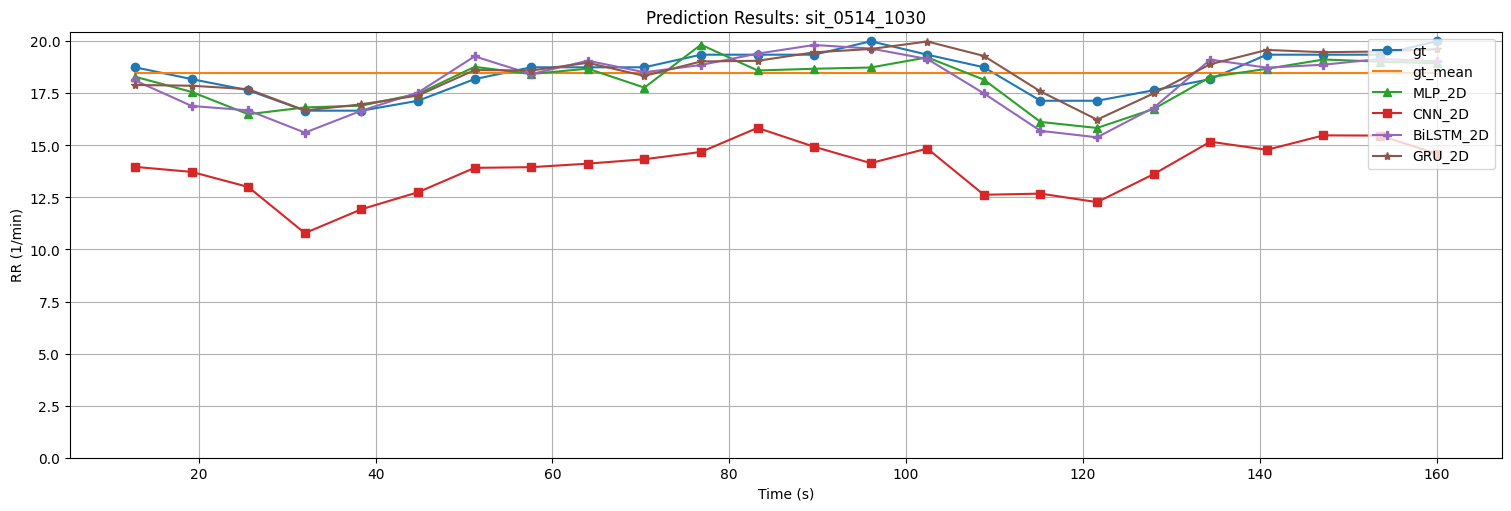

In [14]:
# avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_1D", "CNN_1D"], gt=gts_file, times=times_file, action_name=action_name)
avg_mse_loss, avg_l1_loss, preds = evaluate_models_file(models, file_loader, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], gt=gts_file, times=times_file, action_name=action_name)

## Testing Actions

In [19]:
# Load dataset
dataset_dir = "dataset/action"
dataset_name = "8P_16_2D"
pkl_test = pickle.load(open(os.path.join(dataset_dir, f'{dataset_name}_test.pkl'), 'rb'))
input_test, gt_test = pkl_test['input'], pkl_test['gt']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

first_key = next(iter(input_test))
num_channels = input_test[first_key].shape[1]
num_freq_bins = input_test[first_key].shape[2]
num_time_steps = input_test[first_key].shape[3]

action_order = ['sit', 'stand', 'walk', 'run']
input_test = {k : input_test[k] for k in action_order}
gt_test = {k : gt_test[k] for k in action_order}
print('Testing data......')
for k, v in input_test.items():
    print(f'action: {k}')
    # print(f'input_test[{k}]:{input_test[k].shape}')
    # print(f'gt_test[{k}]:{gt_test[k].shape}')

Testing data......
action: sit
action: stand
action: walk
action: run


In [20]:
# 2-D spectrogram
models_name = ['MLP_8P_2D', 'CNN_8P_2D', 'BiLSTM_8P_2D', 'GRU_8P_2D']
models = [MLP_out1(num_freq_bins, num_time_steps, num_channels=num_channels),
          CNN_out1_2(num_channels=num_channels),
          BiLSTM(num_freq_bins, num_time_steps, num_channels=num_channels),
          GRU(num_freq_bins, num_time_steps, num_channels=num_channels)]

for i in range(len(models_name)):
    models[i].load_state_dict(torch.load(f'./models/{str(models_name[i])}.pt'))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MLP_2D
sit - MSE Loss: 0.0004, L1 Loss: 0.8446 1/min
stand - MSE Loss: 0.0012, L1 Loss: 1.5124 1/min
walk - MSE Loss: 0.0158, L1 Loss: 6.5053 1/min
run - MSE Loss: 0.0050, L1 Loss: 3.5476 1/min

CNN_2D
sit - MSE Loss: 0.0031, L1 Loss: 2.9026 1/min
stand - MSE Loss: 0.0019, L1 Loss: 2.0160 1/min
walk - MSE Loss: 0.0078, L1 Loss: 4.8436 1/min
run - MSE Loss: 0.0025, L1 Loss: 2.5348 1/min

BiLSTM_2D
sit - MSE Loss: 0.0005, L1 Loss: 1.0358 1/min
stand - MSE Loss: 0.0013, L1 Loss: 1.6644 1/min
walk - MSE Loss: 0.0149, L1 Loss: 6.4318 1/min
run - MSE Loss: 0.0028, L1 Loss: 2.4083 1/min

GRU_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.9321 1/min
stand - MSE Loss: 0.0007, L1 Loss: 1.2772 1/min
walk - MSE Loss: 0.0143, L1 Loss: 6.0172 1/min
run - MSE Loss: 0.0044, L1 Loss: 3.2010 1/min



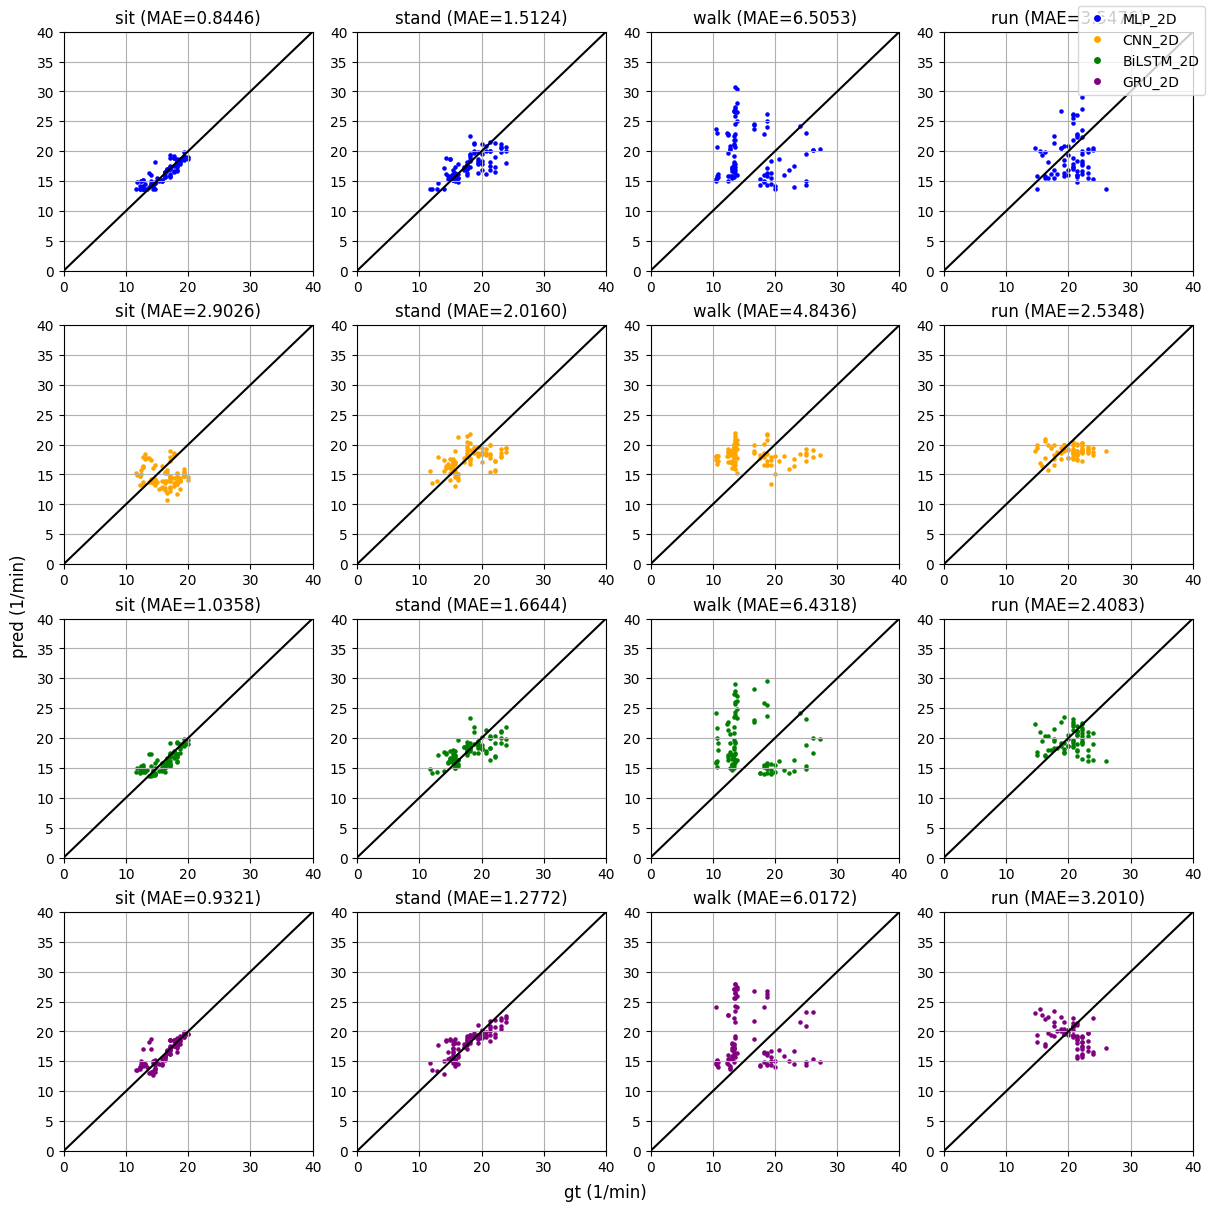

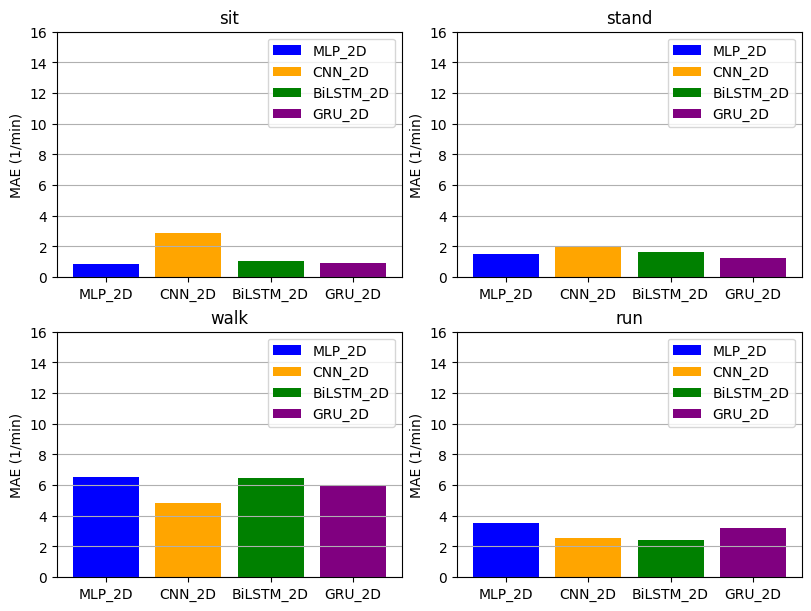

In [21]:
evaluate_models_action(models, input_test, gt_test, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], device=device, visualize=True)

MLP_2D
sit - MSE Loss: 0.0004, L1 Loss: 0.8446 1/min E%: 5.6942%
stand - MSE Loss: 0.0012, L1 Loss: 1.5124 1/min E%: 8.1875%
walk - MSE Loss: 0.0158, L1 Loss: 6.5053 1/min E%: 45.1555%
run - MSE Loss: 0.0050, L1 Loss: 3.5476 1/min E%: 17.2132%

CNN_2D
sit - MSE Loss: 0.0031, L1 Loss: 2.9026 1/min E%: 17.8889%
stand - MSE Loss: 0.0019, L1 Loss: 2.0160 1/min E%: 11.0532%
walk - MSE Loss: 0.0078, L1 Loss: 4.8436 1/min E%: 33.6175%
run - MSE Loss: 0.0025, L1 Loss: 2.5348 1/min E%: 12.4492%

BiLSTM_2D
sit - MSE Loss: 0.0005, L1 Loss: 1.0358 1/min E%: 7.0452%
stand - MSE Loss: 0.0013, L1 Loss: 1.6644 1/min E%: 9.3124%
walk - MSE Loss: 0.0149, L1 Loss: 6.4318 1/min E%: 43.9411%
run - MSE Loss: 0.0028, L1 Loss: 2.4083 1/min E%: 11.9954%

GRU_2D
sit - MSE Loss: 0.0005, L1 Loss: 0.9321 1/min E%: 6.4831%
stand - MSE Loss: 0.0007, L1 Loss: 1.2772 1/min E%: 7.5324%
walk - MSE Loss: 0.0143, L1 Loss: 6.0172 1/min E%: 40.4246%
run - MSE Loss: 0.0044, L1 Loss: 3.2010 1/min E%: 16.1250%



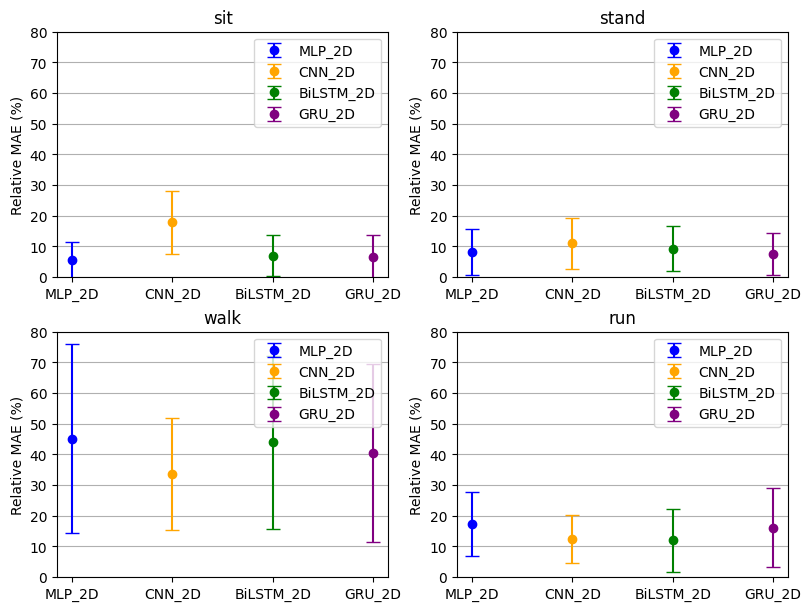

In [22]:
evaluate_models_action_relative(models, input_test, gt_test, models_name=["MLP_2D", "CNN_2D", "BiLSTM_2D", "GRU_2D"], device=device, visualize=True)